# Welcome to the UnicornPost <a class="anchor" id="top"></a>

Congratulations! You have just been hired by UnicornPost, a publisher of news stories that captivate people the world over! Currently, most of your site does not provide a personalized experience, the stories are presented in a static order for all users in a manner controlled by the editorial team. In order to increase page views you are looking to incorporate a recommendation system which assists users in finding the stories they feel are the most intresting and informative.

You’ve been asked by the founders to:

- Provide personalized story recommendation to vistors of your site
- Filter news articles by genre for the relevant parts of the site
- Emphasize newly written articles for certain sections of the site

Throughout the course of this workshop you will be exploring your datasets, building/training several recommendation models and implementing recommendations with API's.

<div class="alert alert-block alert-warning">
<b>Note:</b> importing and training the datasets will take longer than we have in this workshop. In order to complete this workshop within the time set, we have already created several resources on your behalf.  However, the notebooks are designed in such a way that all the steps are included. If the resources have already been created, the cell will return information about the resources, if the resources have not been created, it will create them for you. 
</div>


## In this notebook
In this notebook, you will choose a dataset and prepare it for use with Amazon Personalize.

1. [How to Use the Notebook](#usenotebook)
1. [Introduction to Amazon Personalize Datasets](#datasets)
1. [Choose a Dataset or Data Source](#source)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Create dataset group](#group_dataset)
1. [Create the Item Interactions Schema](#interact_schema)
1. [Create the Items Schema](#items_schema)
1. [Create the Users Schema](#users_schema)
1. [Import the Item Interactions Data](#import_interactions)
1. [Import the Items Metadata](#import_items)
1. [Import the User Metadata](#import_users)
1. [Storing Useful Variables](#vars)

## How to Use the Notebook <a class="anchor" id="usenotebook"></a>

### Executing cells

The code is broken up into cells like the one below. There's a triangular **Run** button at the top of this page that you can click to execute each cell and move onto the next, or you can press `Shift` + `Enter` while in the cell to execute it and move onto the next one.

As a cell is executing, you'll notice an `*` in the checkbox beside the cell. When the cell has finished running, the checkbox will contain a number to indicate the order the cell was executed in with respect to all the other cells in the notebook.

Simply follow the instructions below and execute the cells to get started with Amazon Personalize.

### Understanding the code

This notebook can be used in two modalities:

1. Train as you go by executing each cell. Some cells may take a long time to finish executing as they wait for resources to be created.
2. Use this notebook with previously created resources. All or the majority of the resources will already be created, and cells will just retrieve the information of these existing resources to use them in following steps.

Because of this, you will find that some cells have `try` and `except` blocks. In particular, most of them are handling a `ResourceAlreadyExistsException` exception. 

You can look at the code in the `try` block to get a good idea of how you can create a resource and understand how to use the Amazon Personalize SDK. The `except` block will let you know that the resource has been created and record the corresponding ARN, which is the Amazon unique identifier.

This is an example of the `try` block for creating a dataset group, this code will execute without exceptions if the dataset group does not exist and raise an exception if the dataset group does already exist:

```python
try:     
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    
    create_dataset_group_response = personalize.create_dataset_group(
        name = workshop_dataset_group_name,
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
    print ('\nCreating the Dataset Group with dataset_group_arn = {}'.format(workshop_dataset_group_arn))
```
and this is the corresponding `except` block that will be executed if an exception is raised because the dataset group already exists. This block saves the ARN for the existing dataset group to use later and lets you know the resource already exists.

```python
except personalize.exceptions.ResourceAlreadyExistsException as e:
    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset group/' + 
        workshop_dataset_group_name 
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(
        workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(
        workshop_dataset_group_arn))
```

Depending on the resource, you may also find that sometimes the code will check from a list of resources to find if a resource exists and then use `if` and `else` blocks to either use the existing resource or create it.

### Let's build!

Python ships with a broad collection of libraries and we need to import those as well as the ones installed to help us like [boto3](https://aws.amazon.com/sdk-for-python/) (AWS SDK for python) and [Pandas](https://pandas.pydata.org/)/[Numpy](https://numpy.org/)  which are core data science tools.

In [57]:
!pip install --upgrade pip
!pip install --upgrade --no-deps --force-reinstall botocore
!pip install lxml


import pandas as pd
import json
from datetime import datetime
from lxml import html
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import re
import warnings
import csv
import sys
import os.path
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import time
from time import sleep
import yaml
import numpy as np

data_dir = "poc_data"
!mkdir $data_dir

  Using cached botocore-1.34.145-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.145-py3-none-any.whl (12.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.145
    Uninstalling botocore-1.34.145:
      Successfully uninstalled botocore-1.34.145
mkdir: cannot create directory ‘poc_data’: File exists


In [58]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

In [59]:
# Get the account id and region to use later
account_id = boto3.client('sts').get_caller_identity().get('Account')
print("account id:", account_id)

with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print("region:", region)

account id: 381491864570
region: us-east-1


If this is a workshop and the resources were created for you, we will retrieve the variables of the resources created.

In [60]:
# Opening JSON files
f = open("params.json")
parameters = json.load(f)

In [61]:
workshop_dataset_group_name = parameters['datasetGroup']['serviceConfig']['name']

interactions_schema_name = parameters['datasets']['interactions']['schema']['serviceConfig']['name']
interactions_dataset_name = parameters['datasets']['interactions']['dataset']['serviceConfig']['name']

items_schema_name = parameters['datasets']['items']['schema']['serviceConfig']['name']
items_dataset_name = parameters['datasets']['items']['dataset']['serviceConfig']['name']

#The following job names are the starting Strings of the job names that can be created
interactions_import_job_name = 'dataset_import_interaction'
items_import_job_name = 'dataset_import_item'
        
for solution in parameters['solutions']:
    # This is currently configured assuming only one solution of this type, if there are multiple 
    # solutions of the same type further configuration is needed.
    if (solution['serviceConfig']['recipeArn'] == 'arn:aws:personalize:::recipe/aws-personalized-ranking'):
        workshop_rerank_solution_name = solution['serviceConfig']['name'] 
        # This is currently configured assuming only one campaign, if there are multiple campaigns 
        # further configuration is needed.
        workshop_rerank_campaign_name = solution['campaigns'][0]['serviceConfig']['name']
        
        
    if (solution['serviceConfig']['recipeArn'] == 'arn:aws:personalize:::recipe/aws-user-personalization'):
        workshop_userpersonalization_solution_name = solution['serviceConfig']['name'] 
        # This is currently configured assuming only one campaign, if there are multiple campaigns 
        # further configuration is needed.
        workshop_userpersonalization_campaign_name = solution['campaigns'][0]['serviceConfig']['name'] 

we will make sure we can use the SDK to interact with Amazon Personalize by describing some of the pre-created resources used in the workshop. 

<div class="alert alert-block alert-warning">
<b>Note:</b> If you have not pre-deployed resources and are building them as you go with this notebook, the below cell will raise an exception. You can continue with the notebook and create resources and train models as you go.
</div>

If you have not pre-deployed resources and are building them as you go with this notebook, the below cell will raise an exception. You can continue with the notebook and create resources and train models as you go.

In [62]:
try:
    # Describe a few resources using the SDK
    workshop_rerank_solution_arn = 'arn:aws:personalize:'+region+':'+account_id+':solution/'+workshop_rerank_solution_name
    describe_response = personalize.describe_solution(solutionArn = workshop_rerank_solution_arn)
    print("SDK and resource check SUCCEEDED!")
except:
    print("SDK check FAILED. Proceed to the next cell if you will be uploading data and training models as you go.")
    raise

SDK check FAILED. Proceed to the next cell if you will be uploading data and training models as you go.


ResourceNotFoundException: An error occurred (ResourceNotFoundException) when calling the DescribeSolution operation: The given solution does not exist: arn:aws:personalize:us-east-1:381491864570:solution/immersion_day_personalized_ranking_news

## Introduction to Amazon Personalize Datasets <a class="anchor" id="datasets"></a>
[Back to top](#top)

[Amazon Personalize](https://aws.amazon.com/personalize/) is a fully managed machine learning service that uses your data to generate item recommendations for your users. It can also generate user segments based on users’ affinity for certain items or item metadata.

Regardless of the use case, the algorithms all learn user-item-interaction data, which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

Very often, your data will not arrive in a perfect form for Amazon Personalize from other systems (such as a product catalog, Customer Relationship Management (CRM) System, ...) and you will have to modify it to be structured correctly. This notebook guides you through that process.

### Items data

The Item data consists of information about the articles that users interact with, this data typically comes from some sort of content management platform personalize can process one `textual` field which is recommended to be the article content or a summary of the article content if possible. This dataset can also contain information about the genre or section an article belongs in so that it can be filtered appropriately if needed

### Item-Interactions data

The item-interaction data consists of information about the interactions the readeers of the fictional news site will have with the articles published there. This usually comes from analytics tools or Customer Data Platform's (CDP). The best interaction data for use for Amazon Personalize would include the sequential order of user behavior, what content was clicked on/redand the order it was interacted with. We will be using the CI&T Deskdrop Dataset for both our items (in this case news articles) and our item interactions. Note for a typical news company you may want to filter out some of the interactions if they do not include a sufficient time on page or scroll depth in the article as personalize item-interactions should only respresent a positive interaction between the item and the user

### User data

The user data is what information you have about your users, it typically comes from Customer Relationship Management (CRM) system it is not required for amazon personalize recipies. In this case we will not be using user data.

![Workflow](Images/01_Data_Layer_Resources.jpg)

### Open and Explore the News Interactions Dataset

For this example, we are using public dataset which contains interactions between users and news articles in an internal chat platform. This dataset was initially obtained from https://www.kaggle.com/datasets/gspmoreira/articles-sharing-reading-from-cit-deskdrop

In [64]:
interaction_data = pd.read_csv("https://d2peeor3oplhc6.cloudfront.net/personalize-news-immersion-day/users_interactions.csv")
interaction_data.head(5)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


Amazon Personalize requires only three datafields in the interactions dataset.
    
1. `User_Id`: A unique identifier for an individual user
1. `Item_Id`: A unique itendifier for the item the user in question chose to interact with
1. `Timestamp`: The time of the interaction

lets take a look at what we have

In [65]:
interaction_data.columns

Index(['timestamp', 'eventType', 'contentId', 'personId', 'sessionId',
       'userAgent', 'userRegion', 'userCountry'],
      dtype='object')

In this case it appears we have all the data we need - we will just need to remap some of the column names such as `contentId` to `Item_Id` and `personId` to `User_Id`, personalize can process event types and even filter on them for training purposes though we will need to make a slight alteration to the column name there as well. Amazon Personalize can also use `sessionId` as well.

In [66]:
interaction_data.rename(columns={'contentId': 'item_id',
                            'eventType': 'event_type',
                            'personId': 'user_id',
                            'sessionId': 'session_id'}, inplace=True)

First lets check what unique field names we have in the eventType field:

In [67]:
interaction_data.event_type.value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: event_type, dtype: int64

Amazon Personalize thinks all of the interactions fed to it are representations of postive inclination between the user and the item - so we should discard any event types that do not represent positive inclination, such as thumbs down or a poor review, the above seems to all be positive interactions - so we wont remove any.

Next lets get a bit more of an idea of what is in the other columns

In [68]:
interaction_data.userAgent.value_counts()

Android - Native Mobile App                                                                                                                  6761
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                               1823
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                               1146
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                    1076
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                1059
                                                                                                                                             ... 
Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:50.0) Gecko/20100101 Firefox/50.0                                               

In [69]:
interaction_data.userCountry.value_counts()

BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
IN        3
ES        3
IT        2
MY        2
CN        1
CL        1
NL        1
CO        1
CH        1
Name: userCountry, dtype: int64

With Amazon Personalize it is smart to group our categories where possible - the exact version number of a users browser likely doesnt matter - however whether they are logging on from a mobile device or a desktop probably does. We will ignore tha users region and country for this demo as we are not certain of how they are generated or whether or not they will be availible at inference.

In [70]:
np.nansum((interaction_data.userAgent.str.contains('Mobile')))

7433

how many users do we not know the agent for

In [71]:
sum(interaction_data.userAgent.isna())

15394

Lets replace these values with a string

In [72]:
interaction_data.userAgent.fillna("UnknownAgent", inplace = True)

The function below will group our user device categories into three families

In [73]:
def device_type(user_device_type_raw: str) -> str:
    if 'Mobile' in str(user_device_type_raw):
        return 'Mobile'
    elif user_device_type_raw == "UnknownAgent":
        return "UnknownAgent"
    else:
        return 'NonMobile'

In [74]:
interaction_data['user_device_type'] = interaction_data.userAgent.apply(device_type)

In [75]:
interaction_data['user_device_type'].value_counts()

NonMobile       49485
UnknownAgent    15394
Mobile           7433
Name: user_device_type, dtype: int64

Lets keep this column - as we likely know it with a degree of certainty when the user logs in and it is also likely to affect the type of content they will wish to consume. We will also keep the `timestamp`, `item_id` and `user_id` columns which are needed for personalize - as well as the `event_type` column and `session id` as well

In [76]:
interaction_data = interaction_data[["timestamp","event_type","item_id","user_id","session_id","user_device_type"]]

What does our distribution of interactions accross our various items look like

In [77]:
interaction_data.item_id.value_counts()

-4029704725707465084    433
-133139342397538859     315
 8657408509986329668    294
-6783772548752091658    294
-6843047699859121724    281
                       ... 
 2824996248683640175      1
 7029834616968294970      1
 7697593937932606048      1
-7108012586837980940      1
 7526977287801930517      1
Name: item_id, Length: 2987, dtype: int64

We have 2987 items represented in our interactions dataset - how many of these items have more than 5 interactions

In [78]:
np.mean(interaction_data.item_id.value_counts() > 5)

0.7643120187479076

How many unique users do we have

In [79]:
interaction_data.user_id.value_counts()

-1032019229384696495    1885
-1443636648652872475    1616
 3609194402293569455    1435
-2626634673110551643    1084
-3596626804281480007     903
                        ... 
-5749772120640063461       1
-8050113247491924905       1
-3410401356987328689       1
 4674800004298965524       1
 3357462296682851629       1
Name: user_id, Length: 1895, dtype: int64

What percentage of users have at least 5 interactions

In [80]:
np.mean(interaction_data.user_id.value_counts() > 5)

0.6437994722955145

64% of users have a history of at least 5 interactions these are very healthy numbers for training a personalize model, personalize can work for cold start users but it is nice that we have a healthy population of users with a decent number of interactions in our dataset.

In [81]:
interaction_data.head(10)

,timestamp,event_type,item_id,user_id,session_id,user_device_type
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,UnknownAgent
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,NonMobile
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,UnknownAgent
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,UnknownAgent
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,UnknownAgent
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,NonMobile
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,UnknownAgent
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,NonMobile
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,UnknownAgent
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,UnknownAgent


Lets check for the percentage of nulls in each column

In [82]:
interaction_data.isnull().mean()

timestamp           0.0
event_type          0.0
item_id             0.0
user_id             0.0
session_id          0.0
user_device_type    0.0
dtype: float64

Lets check the timestamp to make sure they are formatted properly for Personalize, the following code below will change a Unix Epoch time (in seconds) timestamp (which is what personalize requires) to a human readable timestamp.

In [83]:
def custom_func(numerictime: int) -> str:
    """
    This function takes a numeric field representing epoch time as its argument and returns a human readable timestamp 
    
    :type numerictime: int
    :param numerictime: timestamp in unix epoch time measured in seconds from January 1, 1970
    
    :rtype: string
    :returns: a string representing a human readable timestamp in the format '%Y-%m-%d %H:%M:%S'
    """
    return datetime.utcfromtimestamp(numerictime).strftime('%Y-%m-%d %H:%M:%S')

In [84]:
interaction_data.timestamp.apply(custom_func)

0        2016-06-08 19:10:32
1        2016-06-08 19:02:40
2        2016-06-08 20:03:10
3        2016-06-08 19:24:55
4        2016-06-08 18:58:10
                ...         
72307    2017-01-23 16:53:45
72308    2017-01-23 16:53:45
72309    2017-01-23 16:47:52
72310    2017-01-23 16:53:54
72311    2017-01-23 16:13:08
Name: timestamp, Length: 72312, dtype: object

Looks good - lets save our data the code below is formatting code for pandas that helps personalize process the data correctly.

In [85]:
interactions_file_name = "deskdrop_interactions_automated.csv"

interaction_data.to_csv("poc_data/" + interactions_file_name,
                            index=False, 
                            float_format='%.0f',
                            quoting=csv.QUOTE_NONNUMERIC,
                            doublequote=False,
                            escapechar='\\')

Now lets create a schema for our dataset:

## Create the Interactions Schema <a class="anchor" id="interact_schema"></a>
[Back to top](#top)

Now that we've loaded and prepared our interactions dataset we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations. Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format. 

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

#### Interactions Dataset Schema

The interactions dataset has three required columns: `ITEM_ID`, `USER_ID`, and `TIMESTAMP`. The `TIMESTAMP` represents when the user interated with an item and must be expressed in Unix timestamp format (seconds). For this dataset we also have an `EVENT_TYPE` column that includes the type of interaction with the article (`VIEW`, `FOLLOW`, `LIKE` ect).

The interactions dataset supports metadata columns. Interaction metadata columns are a way to provide contextual details that are specific to an interaction such as the user's current device type (phone, tablet, desktop, set-top box, etc), the user's current location (city, region, metro code, etc), current weather conditions, and so on. For this dataset, we have a `user_device_type` column that indicates what sort of device the user is logging into the site from, mobile or non-mobile - as this will likely influnce the sort of articles they want to engage with. Note that the `user_device_type` column is annotated as being categorical (`"categorical": true`) this is required if we want personalize to use it as part of its modeling.

If we didn't want personalize to model off of it - we could insert it as merely a string field in which case we could still use it for filtering. Personalize will process the most frequent 1000 categories individually and bundle the remaining categories into a 1001 category. If this isn't ideal for your use case you may want to manually bundle categories yourself.

In [86]:
interactions_schema = {
	"type": "record",  
	"name": "Interactions",  
	"namespace": "com.amazonaws.personalize.schema",  
	"fields": [  
		{  
			"name": "USER_ID",  
			"type": "string"  
		},  
		{  
			"name": "ITEM_ID",  
			"type": "string"  
		},  
		{  
			"name": "TIMESTAMP",  
			"type": "long"  
		}, 
		{  
			"name": "SESSION_ID",  
			"type": "string"  
		},  
		{  
			"name": "EVENT_TYPE",  
			"type": "string"  
		},  
		{  
			"name": "user_device_type",  
			"type": [  
				"null",  
				"string"  
			],  
			"categorical": True  
		}  
	],  
	"version": "1.0"  
}  

In [87]:
try:
    # Try to create the interactions dataset schema, this block with exectute fully 
    # if the interactions dataset schema does not exist yet
    create_schema_response = personalize.create_schema(
        name = interactions_schema_name,
        schema = json.dumps(interactions_schema),
    )
    print(json.dumps(create_schema_response, indent=2))
    workshop_interactions_schema_arn = create_schema_response['schemaArn']
    print ('\nCreating the Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset schema already exists, get the unique identifier workshop_interactions_schema_arn
    # from the existing resource 
    
    workshop_interactions_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+interactions_schema_name 
    print('The schema {} already exists.'.format(workshop_interactions_schema_arn))
    print ('\nWe will be using the existing Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))

The schema arn:aws:personalize:us-east-1:381491864570:schema/immersion_day_news_interactions_schema already exists.

We will be using the existing Interactions Schema with workshop_interactions_schema_arn = arn:aws:personalize:us-east-1:381491864570:schema/immersion_day_news_interactions_schema


## Preparing our Items (Articles) Metadata

Now that we have created the schema lets take a look at our items data (in this case data on our articles)

In [88]:
articles = pd.read_csv("https://d2peeor3oplhc6.cloudfront.net/personalize-news-immersion-day/shared_articles.csv")

What type of fields do we have:

In [89]:
articles.columns

Index(['timestamp', 'eventType', 'contentId', 'authorPersonId',
       'authorSessionId', 'authorUserAgent', 'authorRegion', 'authorCountry',
       'contentType', 'url', 'title', 'text', 'lang', 'english_text',
       'orig_language', 'article_summary', 'article_hook', 'article_trigger',
       'article_genre'],
      dtype='object')

### Sample Text

In [90]:
print(articles.text[0])

O Uber anunciou nesta segunda-feira, 13/06, o lançamento em São Paulo de um projeto piloto para oferecer viagens de helicóptero sob demanda na capital paulista em parceria com a Airbus Group. Chamado de UberCOPTER, o serviço está disponível a partir de hoje, 13/06, e ficará (literalmente) no ar por um mês. De acordo com a empresa, São Paulo é a primeira cidade no mundo a receber esse tipo de serviço - algo que não é realmente uma surpresa, já que a capital é conhecida globalmente pela enorme quantidade de carros e um dos piores trânsitos do planeta. O novo UberCOPTER conectará 5 helipontos (Blue Tree Faria Lima, Helicentro Morumbi, Sheraton WTC, Hangar ABC, Hotel Transamerica) e 4 aeroportos (Congonhas, Cumbica, Viracopos e Campo de Marte) na cidade de SP e regiões próximas e terá preços fixos, que serão mostrados antes do usuário solicitar a viagem. Até o dia 16/06, o serviço terá preços promocionais para alguns trechos, como uma viagem do heliponto do Blue Tree Faria Lima para o aero

### Check for article duplicates

In [91]:
articles.contentId.value_counts().value_counts()

1    2993
2      63
3       1
Name: contentId, dtype: int64

In [92]:
articles.contentId.value_counts()

-2990485643677949494    3
-7356135999773525293    2
-456574518348806233     2
 4106497696154898573    2
-7358932766266901263    2
                       ..
-3020916840917845519    1
-3015446245469915661    1
-2976850014387537414    1
-2976309714446243509    1
-3071732669882279801    1
Name: contentId, Length: 3057, dtype: int64

Which article has three interactions

In [93]:
articles[articles.contentId == -2990485643677949494]

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,english_text,orig_language,article_summary,article_hook,article_trigger,article_genre
1050,1461864561,CONTENT SHARED,-2990485643677949494,-3390049372067052505,-7303988376323787105,NaN,NaN,NaN,HTML,https://hbr.org/2016/04/the-secret-history-of-...,The Secret History of Agile Innovation,Create a FREE account to: Get eight free artic...,en,Create a FREE account to: Get eight free artic...,en,Here is a more concise summary of the key poin...,A concise summary of Harvard Business Review's...,Here are three pieces of information for the g...,other
1051,1461864719,CONTENT REMOVED,-2990485643677949494,-3390049372067052505,-7303988376323787105,NaN,NaN,NaN,HTML,https://hbr.org/2016/04/the-secret-history-of-...,The Secret History of Agile Innovation,Create a FREE account to: Get eight free artic...,en,Create a FREE account to: Get eight free artic...,en,Here is a more concise summary of the key poin...,A concise summary of Harvard Business Review's...,Here are three pieces of information for the g...,other
1052,1461864769,CONTENT REMOVED,-2990485643677949494,-3390049372067052505,-7303988376323787105,NaN,NaN,NaN,HTML,https://hbr.org/2016/04/the-secret-history-of-...,The Secret History of Agile Innovation,Create a FREE account to: Get eight free artic...,en,Create a FREE account to: Get eight free artic...,en,Here is a more concise summary of the key poin...,A concise summary of Harvard Business Review's...,Here are three pieces of information for the g...,other


How many event types do we have:

In [94]:
articles.eventType.value_counts()

CONTENT SHARED     3047
CONTENT REMOVED      75
Name: eventType, dtype: int64

How many articles do we have in each langauge

In [95]:
articles.lang.value_counts()

en    2803
pt     311
la       4
ja       2
es       2
Name: lang, dtype: int64

These are only supposed to be in english and portugese lets take a look at some of the other langauge examples

In [96]:
articles[articles.lang.isin(['la','es','ja'])][['title','text', 'lang', 'contentId']]

,title,text,lang,contentId
1,Request lesson : How and when to use はず(=hazu)...,= Kotoshi no aki made niwa kare ga dekiru hazu...,la,-9216926795620865886
87,"Within a Decade, Retail Banks will be Dead","A соuрlе of weeks ago, I found myself sitting ...",la,-8854146354650101086
221,git flow with support,"Lorem ipsum dolor sit amet, consectetur adipis...",la,-8083832514395551465
222,git flow with support,"Lorem ipsum dolor sit amet, consectetur adipis...",la,-8083832514395551465
646,40 Basic Japanese conversations,Japanese conversation using Ninja LINE sticker...,ja,-5527182266336855540
815,"The Algorithm March, Japan's Strangely Enterta...",Arugorizumu Koushin! アルゴリズムこうしん (Algorithm Mar...,ja,-4434534460030275781
2215,La RAE lucha contra los anglicismos con una ca...,La Real Academia Española alerta sobre su abus...,es,4012770927504386801
2324,Costa Rica presenta su primer edificio constru...,"San José, 22 abr (EFE).- Autoridades de Costa ...",es,4654349179360175629


In [97]:
articles[articles.lang.isin(['la','es','ja'])].text[221]

'Lorem ipsum dolor sit amet, consectetur adipisicing elit. Sint, ducimus, qui fuga corporis veritatis doloribus iure nulla optio dolores maiores dolorum ullam alias cum libero obcaecati cupiditate sit illo aperiam possimus voluptatum similique neque explicabo quibusdam aspernatur dolorem. Quod, corrupti magni explicabo nam sequi nesciunt accusamus aliquam dolore!'

This is placeholder used in UI development lets drop all these articles for simplicity sake

In [98]:
contentIds_to_drop = articles[articles.lang.isin(['la','es','ja'])].contentId

In [99]:
articles.drop(articles.loc[articles.contentId.isin(contentIds_to_drop)].index, inplace=True)

Lets also drop the removal tags

In [100]:
articles.drop(articles.loc[articles.eventType == 'CONTENT REMOVED'].index, inplace=True)

How many duplicates do we have left?

In [101]:
articles.contentId.value_counts().value_counts()

1    3040
Name: contentId, dtype: int64

Personalize can only process one textual field and we have several - first which fields are potentially strings?

In [102]:
articles.dtypes

timestamp           int64
eventType          object
contentId           int64
authorPersonId      int64
authorSessionId     int64
authorUserAgent    object
authorRegion       object
authorCountry      object
contentType        object
url                object
title              object
text               object
lang               object
english_text       object
orig_language      object
article_summary    object
article_hook       object
article_trigger    object
article_genre      object
dtype: object

All fields labeld as object could be strings - how many distinct values do we have in each field?

In [103]:
articles.nunique()

timestamp          3039
eventType             1
contentId          3040
authorPersonId      251
authorSessionId    2004
authorUserAgent     114
authorRegion         19
authorCountry         5
contentType           3
url                3016
title              2996
text               3006
lang                  2
english_text       3006
orig_language         2
article_summary    3025
article_hook       3024
article_trigger    2719
article_genre         7
dtype: int64

We will drop all of the information on the author as it shouldn't be relevant. `eventType` is singular after we dropped other articles so we will drop it.  `contentType`, `lang`, and `article_genre` have low cardinality so they are likely categorical - that leaves potential text fields as

1. Title
1. Text
1. article_summary
1. article_hook
1. article_trigger
1. article_genre

Lets examine each one.

In [104]:
articles.title

0       Uber lança serviço de helicóptero em SP com pr...
2       STEMTera, uma protoboard com Arduino Uno embutido
3       Chrome OS now has Material Design for the desktop
4                             The Real Product Market Fit
5       Eddy Cue and Craig Federighi Open Up About Lea...
                              ...                        
3117    Conheça a Liga IoT, plataforma de inovação abe...
3118    Meet Mycroft, the open source AI who wants to ...
3119    Ray Kurzweil Predicts Three Technologies Will ...
3120                                            Angular 2
3121    Deep-learning neural network creates its own i...
Name: title, Length: 3040, dtype: object

Some of these are in english and some in portugese as expected

In [105]:
articles.text[4]

'Michael Seibel, Y Combinator Partner, on knowing when you\'ve found product market fit and when to keep looking. For weekly recaps of The Macro, sign up here . I often talk to founders who believe they\'ve found product/market fit when they haven\'t. This is a huge problem because they start hiring people, increasing burn, and optimizing their product before they\'ve actually discovered what needs to be built. I\'m writing this post to help you understand when you\'ve really found product/market fit. To start, read Marc Andreessen\'s " On product/market fit for startups ". It has been the single most influential post for me as an entrepreneur and was the first time I ever read the term. Here\'s how Andreessen defines product/market fit: The customers are buying the product just as fast as you can make it -- or usage is growing just as fast as you can add more servers. Money from customers is piling up in your company checking account. You\'re hiring sales and customer support staff as

This is the raw text of the article it looks reasonably long - personalize has a limit of 20000 characters in one individual field - what is the max number of characters in this field

In [106]:
articles.text.apply(len).max()

122568

Thats too many what about the summary is that any better?

In [107]:
articles.article_summary[4]

'Michael Seibel, a Y Combinator partner, shares insights on recognizing true product-market fit. Reaching product-market fit means being overwhelmed with happy, loyal, and ideally paying customers - not just having funding or employees. Founders often mistake signals like funding for product-market fit. The real opportunity lies in solving a burning market problem that customers desperately need solved, even with an imperfect initial solution. Founders should choose a market with acute customer pain, launch quickly with an MVP, and iterate based on user feedback. Only after achieving product-market fit should founders optimize the core product, hire specialists, and make strategic investments. Seibel emphasizes focusing on the market problem first, as the "market pulls product out of the startup." Finding product-market fit unlocks further progress that most startups never reach.'

In [108]:
articles.article_summary.apply(len).max()

37231

<Axes: ylabel='Frequency'>

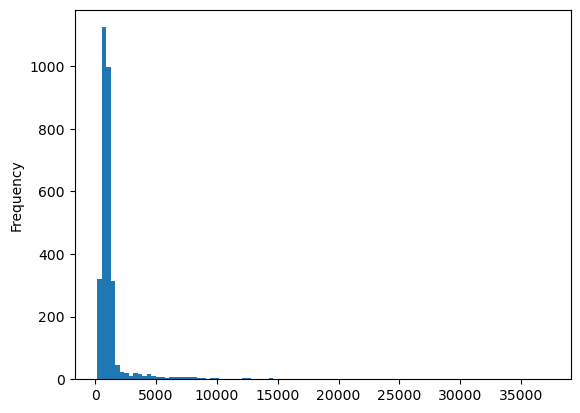

In [109]:
articles.article_summary.apply(len).plot.hist(bins=100)

Longer summaries look rare - how many of them are longer than personalizes limit of 20000 characters?

In [110]:
sum(articles.article_summary.apply(len) > 20000)

5

Only 5 

Still longer than desired - much better however  - its certainly useful to feed the text of the article to personalize and in this case the summary looks like a much better option now lets take a look at the `article_trigger` and the `article_hook`.

In [112]:
articles.article_trigger[4]

'Recognizing true product-market fit is key for startups'

In [113]:
articles.article_hook[4]

'Y Combinator partner Michael Seibel shares insights on achieving product-market fit by solving a burning market problem customers desperately need solved, even with an imperfect initial solution.'

Typically on a website you would see the hook and the trigger displayed along with an image in someway like this:
    
[Ethereum platform enables decentralized blockchain applications.](https://somewebsite.com) The Ethereum platform allows developers to build decentralized blockchain applications through smart contracts. Major banks and tech companies are experimenting with it.

For the sake of training a personalize model we will need to create one text field. To do these we can either drop the unwanted fields or combine the text fields together. We know that users will first see the `article_hook` and the `article_trigger` and then read the text - in this case the `text` field is too long so we will use `article_summary` in place. The best thing to do is probably to concatenate the text fields as follows:

`article_trigger` + `article_hook` + `article_summary`

In [114]:
articles['training_text'] = articles['article_trigger'] +  '\n\n' + articles['article_hook'] + '\n\n' +  articles['article_summary']

In [116]:
print(articles['training_text'][4])

Recognizing true product-market fit is key for startups

Y Combinator partner Michael Seibel shares insights on achieving product-market fit by solving a burning market problem customers desperately need solved, even with an imperfect initial solution.

Michael Seibel, a Y Combinator partner, shares insights on recognizing true product-market fit. Reaching product-market fit means being overwhelmed with happy, loyal, and ideally paying customers - not just having funding or employees. Founders often mistake signals like funding for product-market fit. The real opportunity lies in solving a burning market problem that customers desperately need solved, even with an imperfect initial solution. Founders should choose a market with acute customer pain, launch quickly with an MVP, and iterate based on user feedback. Only after achieving product-market fit should founders optimize the core product, hire specialists, and make strategic investments. Seibel emphasizes focusing on the market pro

How many are above 20,000 characters now?

In [118]:
sum(articles.training_text.apply(len) > 20000)

5

Now we need to check to see the coverage of text accross our dataset. Amazon Personalize will only consider text fields if they are at least 85% full - if our text data is not 85% full then we can put in place holders for any missing text - lets check

In [119]:
articles['training_text'].isna().sum() / articles['training_text'].shape[0]

0.0

OK so for this dataset 0% of the text is missing if the text was missing we could replace it with some kind of placeholder as follows

In [120]:
articles['training_text'].fillna(value="MISSING TEXT", inplace=True)

looks good - now lets drop all the fields we do not need we will keep only the following fields:

1. timestamp
1. contentId
1. ARTICLE_GENRE
1. training_text
1. lang

In [121]:
articles_mlfeatures = articles.drop(columns=articles.columns[~articles.columns.isin(['timestamp', 'contentId', 'article_genre', 'training_text', 'lang'])])

In [122]:
What type of genres do we have out of curiosity?

Object `curiosity` not found.


In [123]:
articles.article_genre.value_counts()

tech                     1213
design best practices     460
ai                        419
other                     306
portugese                 300
cloud provider news       231
crypto currency           111
Name: article_genre, dtype: int64

Once again Amazon Personalize requires the identifier of an item to be called `item_id` as we discussed before - we will also need to rename the `timestamp` column so it can be used appropriately 

In [124]:
articles_mlfeatures.rename(columns={'timestamp': 'creation_timestamp', 
                                   'contentId': 'item_id'}, inplace=True)

Do we have any missing features for any of our articles?

In [125]:
articles_mlfeatures.isna().mean()

creation_timestamp    0.0
item_id               0.0
lang                  0.0
article_genre         0.0
training_text         0.0
dtype: float64

Lets check the timestamp to make sure they are formatted properly for Personalize

In [126]:
articles_mlfeatures.creation_timestamp.apply(custom_func)

0       2016-06-14 02:13:59
2       2017-01-24 14:04:25
3       2016-04-24 20:57:07
4       2016-07-04 17:24:25
5       2016-08-11 05:22:48
               ...         
3117    2017-02-24 14:30:04
3118    2016-06-10 17:57:54
3119    2016-04-20 04:14:39
3120    2016-05-05 14:49:45
3121    2016-04-27 08:54:01
Name: creation_timestamp, Length: 3040, dtype: object

What is the last date that we see

In [127]:
custom_func(articles_mlfeatures.creation_timestamp.max())

'2017-02-28 18:51:11'

What is the first date that we see

In [128]:
custom_func(articles_mlfeatures.creation_timestamp.min())

'2016-03-28 19:39:48'

Lets clean the article text so it can more easily processed by personalize the helper function below processes and cleans the text so that personalize can process it

In [129]:
def process_text(text: str) -> str:
    """
    This function exists to process text prior to using it to create a personalize model it takes as an input a text string and returns a text string
    """

    if type(text) == str:
        html_text = text.replace("<p>&nbsp;</p>", "")  # remove &nbsp from the text
        html_text = html_text.replace("<p></p>", "")  # remove <p></p> from the text
        html_text = html_text.replace("<p> </p>", "")  # remove <p> </p> from the text

        # remove hyper links form the text

        a_pattern = re.compile("<a.*?>")
        html_text = re.sub(a_pattern, "", html_text)
        html_text = html_text.replace("</a>", "")

        # remove spans from the text
        span_pattern = re.compile("<span.*?>")
        html_text = re.sub(span_pattern, "", html_text)
        html_text = html_text.replace("</span>", "")

        class_pattern = re.compile("<class.*?>")
        html_text = re.sub(class_pattern, "", html_text)
        html_text = html_text.replace("</class>", "")

        # remove <b> and </b> from the text
        html_text = html_text.replace("<b>", "")
        html_text = html_text.replace("</b>", "")

        # remove .  . and \n from the text
        html_text = html_text.replace("\n", " ")

        # remove .  . and @ from the text
        html_text = html_text.replace("@", "")

        # remove .  . and - from the text
        html_text = html_text.replace("-", " ")
        
        # add escapes to single quotes
        html_text = html_text.replace("\"", "\\\"")

        # remove HTML
        cleanr = re.compile("^.*?>|<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
        html_text = re.sub(cleanr, "", html_text)

        # remove extra space etc.
        html_text = " ".join(html_text.split())

        # specifics for Amazon dataset
        html_text = html_text.replace(".  .", "")
        warnings.simplefilter("ignore", MarkupResemblesLocatorWarning)
        soup = BeautifulSoup(html_text, "html.parser")
        text = soup.find_all(string=True)

        for index, t in enumerate(text):
            if t[-1] != ".":
                text[index] += "."

        return " ".join(text).strip()

    else:
        return " "
    

In [130]:
articles_mlfeatures.training_text = articles_mlfeatures.training_text.apply(process_text)

One Final Check

In [131]:
articles_mlfeatures.head(5)

,creation_timestamp,item_id,lang,article_genre,training_text
0,1465870439,-9222795471790223670,en,tech,Uber launches on demand helicopter service in ...
2,1485266665,-9194572880052200111,en,tech,STEMtera combines Arduino board with protoboar...
3,1461531427,-9192549002213406534,en,tech,Chrome OS is getting a material design overhau...
4,1467653065,-9190737901804729417,en,design best practices,Recognizing true product market fit is key for...
5,1470892968,-9189659052158407108,en,tech,Apple Executives Discuss Lessons Learned from ...


Looks good lets save and create a schema for this dataset

In [132]:
items_file_name = "deskdrop_articles_automated.csv"

articles_mlfeatures.to_csv("poc_data/" + items_file_name,
                            index=False, 
                            float_format='%.0f',
                            quoting=csv.QUOTE_NONNUMERIC,
                            doublequote=False,
                            escapechar='\\')

## Create the Items (Articles) schema<a class="anchor" id="items_schema"></a>
[Back to top](#top)

The items dataset schema requires an `ITEM_ID` column and at least one metadata column. Up to 100 metadata columns can be added to the items dataset. adding an article `CREATION_TIMESTAMP` is recommended as it will assist personalize with exploration and recommending new articles

For this dataset we have three metadata columns: `LANG`, `ARTICLE_GENRE`, and `TRAINING_TEXT`

Note that `LANG`, `ARTICLE_GENRE` are annotated as being categorical (`"categorical": True`). In this case though we also have a field annotated as textual (`"textual": True`) - personalize can process one text field in its item dataset.

In [133]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CREATION_TIMESTAMP",
            "type": "long"
        },
        {
            "name": "TRAINING_TEXT",
            "type": ["null", "string"],
            "textual": True,
        },
        {
            "name": "LANG",
            "type": "string",
            "categorical": True
        },
        {
            "name": "ARTICLE_GENRE",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

In [134]:
try:
    # Try to create the items dataset schema, this block with exectute fully 
    # if the items dataset schema does not exist yet
    
    create_schema_response = personalize.create_schema(
        name = items_schema_name,
        schema = json.dumps(items_schema),
    )
    workshop_items_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))

    print ('\nCreating the Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset schema already exists, get the unique identifier workshop_items_schema_arn 
    # from the existing resource 
    
    workshop_items_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+items_schema_name 
    print('The schema {} already exists.'.format(workshop_items_schema_arn))
    print ('\nWe will be using the existing Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))

{
  "schemaArn": "arn:aws:personalize:us-east-1:381491864570:schema/immersion_day_news_items_schema",
  "ResponseMetadata": {
    "RequestId": "f40701e7-7497-46a6-9128-809073e45d7f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 22 Jul 2024 13:40:53 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "97",
      "connection": "keep-alive",
      "x-amzn-requestid": "f40701e7-7497-46a6-9128-809073e45d7f",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}

Creating the Items Schema with workshop_items_schema_arn = arn:aws:personalize:us-east-1:381491864570:schema/immersion_day_news_items_schema


# Creating Dataset Group and Importing data <a class="anchor" id="import"></a>

## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to the instance running this Jupyter notebook.  

By default, the Personalize service does not have permission to access the data we upload into  S3 buckets in our account. In order to grant access to the Amazon Personalize service to interact with our S3 Buckets, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume. If you are running this notebook without also running the Pretrained cloud formation template in the root folder then you will need to grant this Notebook substantial permissions in order to be able to run the code correctly.

If you are running this with the pretrained cloud formation template `PersonalizeIDPretrained.yaml` then the notebook will not need that level of permissioning and will obtain the permissions from the bucket created as part of the automation process for demonstration.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

First, let us get the current notebook region.

In [135]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]

# To use a different region use:
# region = <your_region>

print('region:', region)

region: us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalize-poc-publishing` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell. Note if you have already created a bucket as part of the cloud formation automation then the cell below will return information on that previously created bucket.

In [136]:
# Configure the SDK to SSM:
ssm = boto3.client('ssm')
s3 = boto3.client('s3')
bucket_found = False
try:
    personalizes3bucket = ssm.get_parameter(Name='/cloudformation/personalize-s3-bucket', WithDecryption=False)
    bucket_name = personalizes3bucket['Parameter']['Value']
    print('Bucket created as part of cloud formation template found')
    print('bucket_name:', bucket_name)
    bucket_found=True
except:
    
    account_id = boto3.client('sts').get_caller_identity().get('Account')
    bucket_name = account_id + "-" + region + "-" + "personalize-poc-publishing"

    #getting existing buckets in the account
    response = s3.list_buckets()

    if bucket_name in [x['Name'] for x in response['Buckets']]:
        print("The bucket already exists.")
    else:
        if region == "us-east-1":
            bucket_responese = s3.create_bucket(Bucket=bucket_name)
        else:
            bucket_responese = s3.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
                )
    print('bucket_name:', bucket_name)

Bucket created as part of cloud formation template found
bucket_name: test-stack-3-mlopsstack-1ksuxvta-personalizebucket-evtxjufeydvb


Amazon Personalize needs to be able to read the contents of your S3 bucket. The policy which enables personalize to access the contents of the S3 bucket is below.

```python
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}
```

This S3 bucket policy allows Amazon Personalize to be able to read the contents of your S3 bucket. The code below creates and adds the policy to the bucket it created in the last step. If the bucket was created as part of the automation script then it merely shows the bucket that it created.

In [137]:
if bucket_found:
    bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']
    print("Policy for bucket created as part of cloud formation template:")
    print(json.loads(bucket_current_policy))
else:
    policy = {
        "Version": "2012-10-17",
        "Id": "PersonalizeS3BucketAccessPolicy",
        "Statement": [
            {
                "Sid": "PersonalizeS3BucketAccessPolicy",
                "Effect": "Allow",
                "Principal": {
                    "Service": "personalize.amazonaws.com"
                },
                "Action": [
                    "s3:GetObject",
                    "s3:ListBucket",
                    "s3:PutObject"
                ],
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ]
            }
        ]
    }

    bucket_current_policy = None

    try:
        bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']

    except s3.exceptions.from_code('NoSuchBucketPolicy') as e:    
        print("There is no current Bucket Policy for bucket " + bucket_name)

    except Exception as e: 
        raise(e)

    if (bucket_current_policy and policy == json.loads(bucket_current_policy)):
        print ("The policy is already associated with the S3 Bucket.")
    else:
        print ("Adding the policy to the bucket.")
        print(s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy)))

Policy for bucket created as part of cloud formation template:
{'Version': '2012-10-17', 'Id': 'PersonalizeS3BucketAccessPolicy', 'Statement': [{'Effect': 'Allow', 'Principal': {'Service': 'personalize.amazonaws.com'}, 'Action': ['s3:GetObject', 's3:PutObject', 's3:ListBucket'], 'Resource': ['arn:aws:s3:::test-stack-3-mlopsstack-1ksuxvta-personalizebucket-evtxjufeydvb', 'arn:aws:s3:::test-stack-3-mlopsstack-1ksuxvta-personalizebucket-evtxjufeydvb/*']}]}


### Create an IAM role

Amazon Personalize also needs the ability to assume roles in AWS in order to have the permissions to execute certain tasks. Let's create an IAM role and attach the required policies to it. The code below attaches broad policies. You should use [more restrictive, least-privilege policies for production applications](https://docs.aws.amazon.com/IAM/latest/UserGuide/best-practices.html#grant-least-privilege). If you have run the cloud formation template the role will have been automatically created and we will simply obtain that one.

In [138]:
if bucket_found:
    print("Cloud formation template used - skipping creation of IAM role and needed policies for Personalize as they were already created as part of the automation script")
    role_arn_info = ssm.get_parameter(Name='/cloudformation/personalize-iam-role-arn', WithDecryption=False)
    role_arn = role_arn_info['Parameter']['Value']
    role_name = role_arn.split('/')[1]
else:
    iam = boto3.client("iam")

    role_name = account_id+"-PersonalizeS3-Immersion-Day"
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                "Service": "personalize.amazonaws.com"
              },
                "Action": "sts:AssumeRole"
            }
        ]
    }

    # Create policy

    s3_access_policy_document = {
        "Version": "2012-10-17",
        "Statement": {
                "Sid" : "myStatement" ,
                "Effect": "Allow",
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ],
                "Action": "s3:*"
            }
    }

    try: 

        policy_response = iam.create_policy(
            PolicyName='restrictedS3Access',
            PolicyDocument=json.dumps(s3_access_policy_document),
            Description='Restricts access to only workshop S3 bucket'
        )

        s3_access_policy_arn = policy_response['Policy']['Arn']

        print ("s3_access_policy_arn:{}".format(s3_access_policy_arn))
    except:
        s3_access_policy_arn = 'arn:aws:iam::{}:policy/restrictedS3Access'.format(account_id)
        print ('The policy {} already exists.'.format(s3_access_policy_arn))
        print ('Using the existing policy')


    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document),
        );
        role_arn = create_role_response["Role"]["Arn"]

        print ("10s pause to allow role to be fully consistent.")
        time.sleep(10)

    except iam.exceptions.EntityAlreadyExistsException as e:
        print('Warning: role already exists:', e)
        role_arn = iam.get_role(
            RoleName = role_name
        )["Role"]["Arn"];

    print('IAM Role: {}\n'.format(role_arn))

    # Attach the policy if it is not previously attached:
    if (s3_access_policy_arn in [ x['PolicyArn'] for x in iam.list_attached_role_policies( RoleName = role_name)['AttachedPolicies']]):
        print ('The policy {} is already attached to this role.'.format(s3_access_policy_arn))
    else:
        print ("Attaching the role_policy: {}".format(s3_access_policy_arn))
        attach_response = iam.attach_role_policy(
            RoleName = role_name,
            PolicyArn = s3_access_policy_arn
        );
        print ("30s pause to allow role to be fully consistent.")
        time.sleep(30)
        print('Done.')

Cloud formation template used - skipping creation of IAM role and needed policies for Personalize as they were already created as part of the automation script


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV files of our 3 datasets (Item, Interaction and User).

<div class="alert alert-block alert-warning">
<b>Note:</b> NOTE: We will cover how to import real-time data in a future notebook..
</div>

In [139]:
interactions_file_path = data_dir + "/" + interactions_file_name

try:
    s3.get_object(
        Bucket=bucket_name,
        Key=interactions_file_path,
    )
    print("{} already exists in the bucket {}".format(interactions_file_path, bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_file_name).upload_file(interactions_file_path)
    print("File {} uploaded to bucket {}".format(interactions_file_name, bucket_name))

items_file_path = data_dir + "/" + items_file_name
try:
    s3.get_object(
        Bucket=bucket_name,
        Key=items_file_name,
    )
    print("{} already exists in the bucket {}".format(items_file_path, bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist     
    boto3.Session().resource('s3').Bucket(bucket_name).Object(items_file_name).upload_file(items_file_path)
    print("File {} uploaded to bucket {}".format(items_file_name, bucket_name))

except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object(users_file_name).upload_file(users_file_path)
    print("File {} uploaded to bucket {}".format(users_file_name, bucket_name))

File deskdrop_interactions_automated.csv uploaded to bucket test-stack-3-mlopsstack-1ksuxvta-personalizebucket-evtxjufeydvb
poc_data/deskdrop_articles_automated.csv already exists in the bucket test-stack-3-mlopsstack-1ksuxvta-personalizebucket-evtxjufeydvb


## Create dataset group <a class="anchor" id="group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one – they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

We need to create the dataset group that will contain our three datasets.

Your dataset group can be one of the following types:

* A Domain dataset group, where you create preconfigured resources for different business domains and use cases, such as getting recommendations for similar videos (VIDEO_ON_DEMAND domain) or best selling items (ECOMMERCE domain). You choose your business domain, import your data, and create recommenders. You use recommenders in your application to get recommendations. Use a [Domain dataset group](https://docs.aws.amazon.com/personalize/latest/dg/domain-dataset-groups.html) if you have a video on demand or e-commerce application and want Amazon Personalize to find the best configurations for your use cases. If you start with a Domain dataset group, you can also add custom resources such as solutions with solution versions trained with recipes for custom use cases.


* A [Custom dataset group](https://docs.aws.amazon.com/personalize/latest/dg/custom-dataset-groups.html), where you create configurable resources for custom use cases and batch recommendation workflows. You select a recipe, train a solution version (model), and deploy the solution version with a campaign. You use a campaign in your application to get recommendations. Use a Custom dataset group if you don't have a video on demand or e-commerce application or want to configure and manage only custom resources, or want to get recommendations in a batch workflow. If you start with a Custom dataset group, you can't associate it with a domain later. Instead, create a new Domain dataset group.

You can create and manage Domain dataset groups and Custom dataset groups with the AWS console, the AWS Command Line Interface (AWS CLI), or programmatically with the AWS SDKs.

<div class="alert alert-block alert-warning">
<b>Note:</b> If you are running this as part of an AWS workshop, the resources have been created ahead of time, this is to eliminate the time spent waiting for the data to import, models to train and recommenders to deploy. In these notebooks will check to see if the resources exist and use them. You may see “Resource X Already exists” messages, if you run these notebooks in your own account, it will create these resources, which will add approximately 90 minutes to this workshop.
</div>


## Create dataset group for personalized news model <a class="anchor" id="cluster_group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata (out of scope for this workshop)
* Item metadata
* Action metadata (out of scope for this workshop)
* Action interaction data (out of scope for this workshop)

We need to create the dataset group that will contain our two datasets.

#### Create Dataset Group
The following cell will create a new dataset group with the name `personalize-immersion-day-news`.

In [140]:
try:     
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    
    create_dataset_group_response = personalize.create_dataset_group(
        name = 'personalize-immersion-day-news',
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))

    print(f'DatasetGroupArn = {workshop_dataset_group_arn}')
    
except personalize.exceptions.ResourceAlreadyExistsException as e:
    # if the dataset group already exists, get the unique identifier workshop_dataset_group_arn 
    # from the existing resource
    
    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset-group/'+workshop_dataset_group_name 
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(workshop_dataset_group_arn))


{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:381491864570:dataset-group/personalize-immersion-day-news",
  "ResponseMetadata": {
    "RequestId": "994f83ee-f045-4a3d-9eb5-92451964d606",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 22 Jul 2024 13:41:08 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "109",
      "connection": "keep-alive",
      "x-amzn-requestid": "994f83ee-f045-4a3d-9eb5-92451964d606",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:us-east-1:381491864570:dataset-group/personalize-immersion-day-news


#### Wait for Dataset Group to Have ACTIVE Status

Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every 60 seconds, up to a maximum of 3 hours. Note if you are running this notebook as part of an immerion day workshop it is very likely the resources have already been created for you

In [141]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = workshop_dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### Create the interactions dataset

With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a resources needed to hold the data, to do this we reference the schema we created earlier. 

In [142]:
try:
    # Try to create the interactions dataset, this block with exectute fully 
    # if the interactions dataset does not exist yet
    
    dataset_type = 'INTERACTIONS'
    create_dataset_response = personalize.create_dataset(
        name = interactions_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_interactions_schema_arn
    )

    workshop_interactions_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
    print ('\nCreating the Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset already exists, get the unique identifier workshop_interactions_dataset_arn 
    # from the existing resource 
    workshop_interactions_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/INTERACTIONS'
    print('The Interactions Dataset {} already exists.'.format(workshop_interactions_dataset_arn))
    print ('\nWe will be using the existing Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))
        

{
  "datasetArn": "arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "8255a12a-5433-411b-94d2-55f42d55f3e8",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 22 Jul 2024 13:41:40 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "111",
      "connection": "keep-alive",
      "x-amzn-requestid": "8255a12a-5433-411b-94d2-55f42d55f3e8",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}

Creating the Interactions Dataset with workshop_interactions_dataset_arn = arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/INTERACTIONS


### Create Items Dataset
With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a schema of what the data looks like. 

In [143]:
try:
    # Try to create the items dataset, this block with execute fully if the items dataset does not exist yet
    
    dataset_type = "ITEMS"
    create_dataset_response = personalize.create_dataset(
        name = items_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_items_schema_arn
    )

    workshop_items_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))

    print ('\nCreating the Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset already exists, get the unique identifier workshop_items_dataset_arn 
    # from the existing resource 
    
    workshop_items_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/ITEMS'
    print('The Items Dataset {} already exists.'.format(workshop_items_dataset_arn))
    print ('\nWe will be using the existing Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))   

{
  "datasetArn": "arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/ITEMS",
  "ResponseMetadata": {
    "RequestId": "89d4499d-e73c-4a6f-8d7c-3ce4e08e4e60",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 22 Jul 2024 13:41:40 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "104",
      "connection": "keep-alive",
      "x-amzn-requestid": "89d4499d-e73c-4a6f-8d7c-3ce4e08e4e60",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}

Creating the Items Dataset with workshop_items_dataset_arn = arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/ITEMS


Let's wait until all the datasets have been created.

In [144]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_interactions_dataset_arn
    )
    status_interaction_dataset =  describe_dataset_response["dataset"]['status']
    print("Interactions Dataset: {}".format(status_interaction_dataset))
    
    if status_interaction_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_arn))
        
    elif status_interaction_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_arn))
        break
        
    if not status_interaction_dataset == "ACTIVE":
        print("The interaction dataset creation is still in progress")
    else:
        print("The interaction dataset  is ACTIVE")
        

    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_items_dataset_arn
    )
    status_item_dataset =  describe_dataset_response["dataset"]['status']
    print("Items Dataset: {}".format(status_item_dataset))
    
    if status_item_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_arn))
        
    elif status_item_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_arn))
        break
        
    if not status_item_dataset == "ACTIVE":
        print("The item dataset creation is still in progress")
    else:
        print("The item dataset  is ACTIVE")
    
    if status_interaction_dataset == "ACTIVE" and status_item_dataset == "ACTIVE":
        break
        
    time.sleep(30)

Interactions Dataset: CREATE PENDING
The interaction dataset creation is still in progress
Items Dataset: CREATE PENDING
The item dataset creation is still in progress
Interactions Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/INTERACTIONS
The interaction dataset  is ACTIVE
Items Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-immersion-day-news/ITEMS
The item dataset  is ACTIVE
CPU times: user 14.9 ms, sys: 2.05 ms, total: 16.9 ms
Wall time: 30.1 s


## Import the Interactions <a class="anchor" id="import_interactions"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [145]:
# Check if the import job already exists

# List the import jobs
interactions_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_interactions_dataset_arn,
    maxResults=100
)['datasetImportJobs']

#check if there is an existing job with the prefix
job_exists = False  
job_arn = None

for job in interactions_dataset_import_jobs:
    if (interactions_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']
    
if (job_exists):
    workshop_interactions_dataset_import_job_arn = job_arn
    print('The Interactions Import Job {} already exists.'.format(workshop_interactions_dataset_import_job_arn))
    print ('\nWe will be using the existing Interactions Import Job with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))
        
else:
    # If there is no import job with the prefix, create it:   
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = interactions_import_job_name,
        datasetArn = workshop_interactions_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, interactions_file_name)
        },
        roleArn = role_arn
    )
    workshop_interactions_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    
    print ('\nImporting the Interactions Data with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))

InvalidInputException: An error occurred (InvalidInputException) when calling the CreateDatasetImportJob operation: Insufficient privileges for accessing data in S3. Please look at https://docs.aws.amazon.com/personalize/latest/dg/granting-personalize-s3-access.html and ensure your role is configured correctly.

In [146]:
role_arn

'arn:aws:iam::381491864570:role/test-stack-3-PersonalizeIamRole-xf0Cb5B20Qx5'

## Import the Item Metadata <a class="anchor" id="import_items"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [ ]:
# Checking if the import job already exists

# List the import jobs
items_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_items_dataset_arn,
    maxResults=100
)['datasetImportJobs']

job_exists = False
job_arn = None

#check if there is an existing job with the prefix
for job in items_dataset_import_jobs:
    if (items_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']
    
if (job_exists):
    workshop_items_dataset_import_job_arn =  job_arn
    print('The Items Import Job {} already exists.'.format(workshop_items_dataset_import_job_arn))
    print ('\nWe will be using the existing Items Import Job with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))
        
else:
    # If there is no import job with the prefix, create it:    
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = items_import_job_name,
        datasetArn = workshop_items_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, items_file_name)
        },
        roleArn = role_arn
    )

    workshop_items_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    print ('\nImporting the Items Data with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))

### Wait for Import Jobs to Complete

Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every minute, up to a maximum of 6 hours.

It will take 10-15 minutes for the import jobs to complete. While you're waiting you can learn more about Datasets and Schemas in [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

We will wait for all three jobs to finish.

In [ ]:
max_time = time.time() + 6*60*60 # 10 hours
while time.time() < max_time:

    # Interactions dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_interactions_dataset_import_job_arn
    )
    status_interactions_import = describe_dataset_import_job_response["datasetImportJob"]['status']
    
    if status_interactions_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_import_job_arn))
        
    elif status_interactions_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_import_job_arn))
        break
        
    if not status_interactions_import == "ACTIVE":
        print("The interactions dataset import is still in progress")
    else:
        print("The interactions dataset import is ACTIVE")

    # Items dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_items_dataset_import_job_arn
    )
    status_items_import = describe_dataset_import_job_response["datasetImportJob"]['status']
    
    if status_items_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_import_job_arn))
        
    elif status_items_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_import_job_arn))
        break
        
    if not status_items_import == "ACTIVE":
        print("The items dataset import is still in progress")
    else:
        print("The items dataset import is ACTIVE")

    if status_interactions_import == "ACTIVE" and status_items_import == 'ACTIVE':
        break

    print()
    time.sleep(30)

# Filters <a class="anchor" id="filters"></a>

## Create Filters <a class="anchor" id="create-filters"></a>
[Back to top](#top)

Personalize can utilize either [static or dynamic filters](https://docs.aws.amazon.com/personalize/latest/dg/filter.html). Static filters are where the filter properties are built into the filter itself, which makes invocation simpler, but gives less flexibility. An example of this would be an accessories category filter, which invokes the get_recommendations_response api with the specific filter of CATEGORY_L1 = accessories. In order to create a recommendation for each filter, that would require 10+ filters. Personalize also supports dynamic filters, where the values can be passed at runtime, allowing for a single filter of CATEGORY_L1, where the actual category is passed at runtime. 

Filters can be created for fields of both Items and Events. 

A few common use cases for dynamic filters in news are:

* Categorical filters based on Item Metadata - Often your item metadata will have information about the item. Filtering on these can provide recommendations within that data. In particular this is quite useful for recommending specifc news articles for specific sections of a website such as politics, sports, tech and lifestyle

* Range based filters based on Item Metadata - Personalize supports range operations in both static and dynamic filters. Filtering based on a range can be used to create recommendations specific to a specific time range. This can be useful for highlighting articles for specific breakingnews sections.

* Events - you may want to filter out certain events and provide results based on those events, such as removing articles a user has already read from their recommendations

#### Create Genre Filter

Below we are going to create a dynamic fitler for specific genres of articles - our dataset is limited to tech articles so our genres are all specific iterations of that in this case. We will also exclude previously read articles.

In [ ]:
try:
    create_genre_filter_response = personalize.create_filter(
        name = 'breakingnews-genre-filter-5',
        datasetGroupArn = workshop_dataset_group_arn,
        filterExpression = "INCLUDE ItemID WHERE Items.ARTICLE_GENRE IN ($GENRELIST) AND Items.CREATION_TIMESTAMP > $CUTOFF | EXCLUDE ItemID WHERE Interactions.EVENT_TYPE IN (\"*\")" 
    )
    
    genre_filter_arn = create_genre_filter_response['filterArn']
    print('Creating the Personalize filter with category_filter_arn {}.'.format(genre_filter_arn))
    

except personalize.exceptions.ResourceAlreadyExistsException as e:
    genre_filter_arn = 'arn:aws:personalize:'+region+':'+account_id+':filter/'+'breakingnews-genre-filter-5' 
    print('The Personalize filter {} already exists.'.format(genre_filter_arn))

Wait for filter to be created

In [ ]:
status = None
max_time = time.time() + 60*60 # 1 hours
while time.time() < max_time:
    describe_filter_response = personalize.describe_filter(
        filterArn = genre_filter_arn
    )
    status = describe_filter_response["filter"]["status"]
    print("Genre filter: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)
    

NOTE THE CODE BELOW WILL NOT WORK UNLESS YOU ARE RUNNING THIS NOTEBOOK AS PART OF AN AWS WORKSHOP WHERE ALL RESOURCES HAVE BEEN PRECREATED

In [ ]:
sample_user = str(-8845298781299428018)

In [ ]:
workshop_userpersonalization_campaign_arn =  'arn:aws:personalize:'+region+':'+account_id+':campaign/'+workshop_userpersonalization_campaign_name

In [ ]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = workshop_userpersonalization_campaign_arn,
    userId = sample_user,
    numResults = 5,
    filterArn = genre_filter_arn,
    filterValues = {"GENRELIST": "\"tech\"", "CUTOFF": "1465413032"}
)

In [ ]:
print(get_recommendations_response)

We will look at some of these recommendations in more detail in `03_Inference_Layer`

With all imports now complete you can start training your personalization models. Run the cell below before moving on to store a few values for usage in the next notebooks. After completing that cell open notebook `02_Training_Layer.ipynb` to continue.

## Storing Useful Variables <a class="anchor" id="vars"></a>
[Back to top](#top)

Before exiting this notebook, run the following cells to save the version ARNs for use in the next notebook.

In [ ]:
%store data_dir
%store interactions_file_name
%store items_file_name
%store workshop_dataset_group_arn
%store workshop_interactions_dataset_arn
%store workshop_items_dataset_arn
%store workshop_interactions_schema_arn
%store workshop_items_schema_arn
%store genre_filter_arn

%store workshop_rerank_solution_name
%store workshop_rerank_campaign_name

%store workshop_userpersonalization_solution_name
%store workshop_userpersonalization_campaign_name

%store region
%store account_id
%store role_name
%store role_arn

%store bucket_name

%store articles_mlfeatures
%store interaction_data

%store bucket_current_policy